In [1]:
!pip install scikit-optimize
!pip install numpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

#Metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, explained_variance_score

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

#Splitters
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view

#Hyperparameter optimization
from skopt import BayesSearchCV


# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [2]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied,initial_bikes
10006,22,21,2,2022,0,1,1,0,7.9,6.3,87.5,0.0,0.0,4.1,0.0,0.0
2161,1,1,4,2021,3,1,3,0,7.4,5.1,74.4,0.0,0.0,4.9,0.0,0.0
13320,0,10,7,2022,6,0,3,0,23.6,25.7,71.1,0.0,0.0,5.5,0.0,0.0
23287,7,29,8,2023,1,1,3,0,19.9,20.1,69.3,0.0,0.0,8.1,NaN,0.0
12301,13,28,5,2022,5,0,3,6,26.8,28.5,54.5,0.0,0.0,13.6,1.0,16.0


### **Estadísticas descriptivas**

In [3]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hour,25536.0,11.500000,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,15.712406,8.791936,1.0,8.00,16.0,23.00,31.0
month,25536.0,6.366541,3.366900,1.0,3.00,6.0,9.00,12.0
year,25536.0,2021.970865,0.810020,2021.0,2021.00,2022.0,2023.00,2023.0
week_day,25536.0,3.000000,2.000039,0.0,1.00,3.0,5.00,6.0
working_day,25536.0,0.683271,0.465210,0.0,0.00,1.0,1.00,1.0
class_day,25536.0,2.188910,0.931420,1.0,1.00,3.0,3.00,3.0
exits,25536.0,2.257206,3.678230,0.0,0.00,1.0,3.00,42.0
temperature,25536.0,16.985589,7.073900,-1.6,11.60,17.0,22.50,36.8
a_temperature,25536.0,16.598367,8.969706,-6.1,9.50,16.3,24.10,40.3


### **Tratamiento de valores faltantes**

In [4]:
# Contamos los valores faltantes en la columna 'demand_satisfied'
missing_values_count = data['demand_satisfied'].isna().sum()

missing_values_count

# Hacer INPLACE de demand_satisfied N.A provisional:
data['demand_satisfied'].fillna(False, inplace=True)

### **Adaptacion del dataset**

Transformamos 'year', 'month' y 'day' en un timestape que llamamos 'date' para poder filtrar los datos que usaremos. Tambien añadimos 'demand_satisfied_lag' que nos indica si la hora anterior se cumplio la demanda. Como hemos hecho el .fillna() esto no tendra missing values

In [5]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)

# Quitar los registros con valores faltantes
data.dropna(inplace=True)

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-11-01')
end_date = pd.Timestamp('2023-11-30')
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

filtered_data.drop('date', axis=1, inplace=True) #Eliminamos despues del filtrado date ya que es redundante


<ipython-input-5-b88ca001a852>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop('date', axis=1, inplace=True) #Eliminamos despues del filtrado date ya que es redundante


### **Distribución de las variables**

Obviamos las variables que hemos creado ya que estas son para ayudar al modelo o el filtrado, pero al ser hecha a partir de otras variables de nuestro dataset no son relevantes de graficar concretamente.

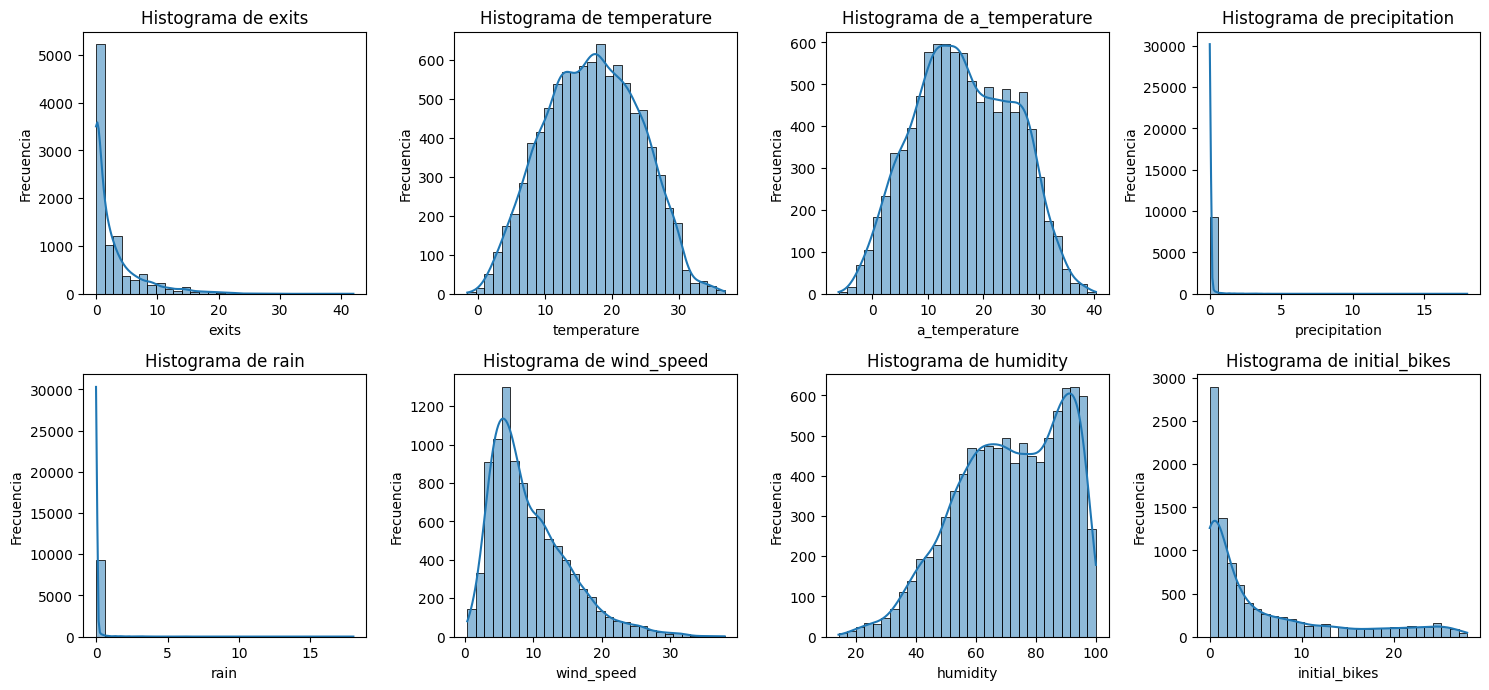

In [6]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity","initial_bikes"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(filtered_data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

Como vemos, rain y precipitation son casi lo mismo. Por lo que nos quedaremos tan solo con precipitation.

In [7]:
filtered_data.drop('rain', axis=1, inplace=True)


<ipython-input-7-4ba2da43f686>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop('rain', axis=1, inplace=True)


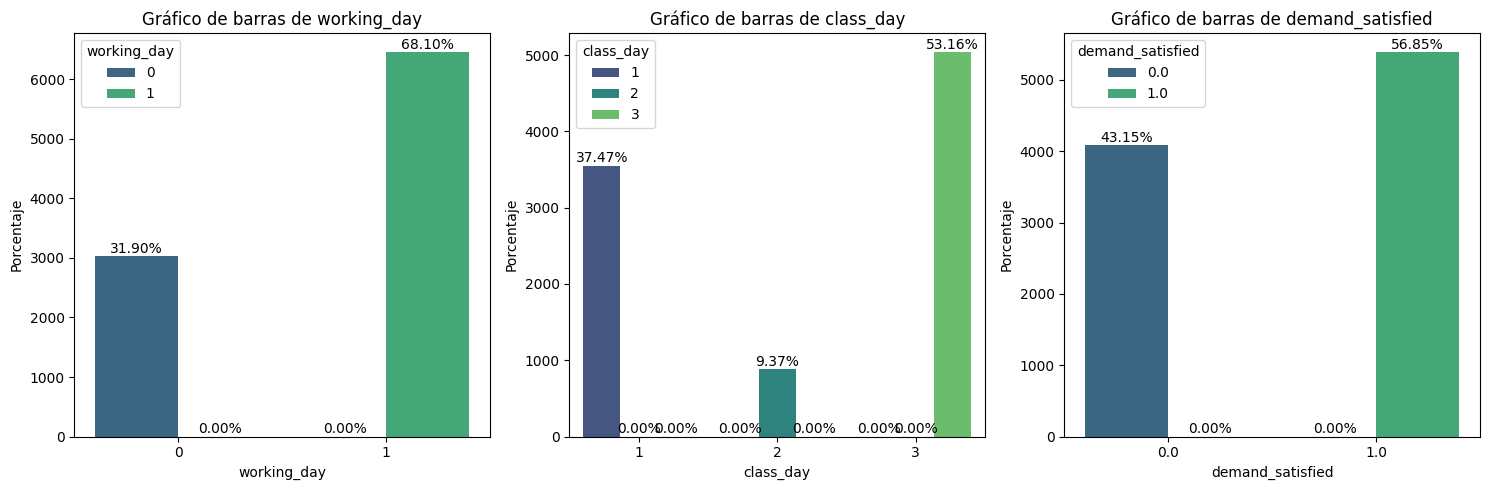

In [8]:
# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day', 'demand_satisfied']

# Plotting bar charts for categorical variables with percentages
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=var, data=filtered_data, hue=var, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')

    # Calculate the percentages and display them on the bars
    total = len(filtered_data[var])  # Total number of records for normalization
    for p in plt.gca().patches:
        height = p.get_height()  # Get the height of each bar
        # Put the annotation on the bar
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}%'.format((height / total) * 100),
                       ha="center", va='bottom')

plt.tight_layout()
plt.show();


### **Realción de la variable objetivo con el resto de variables**

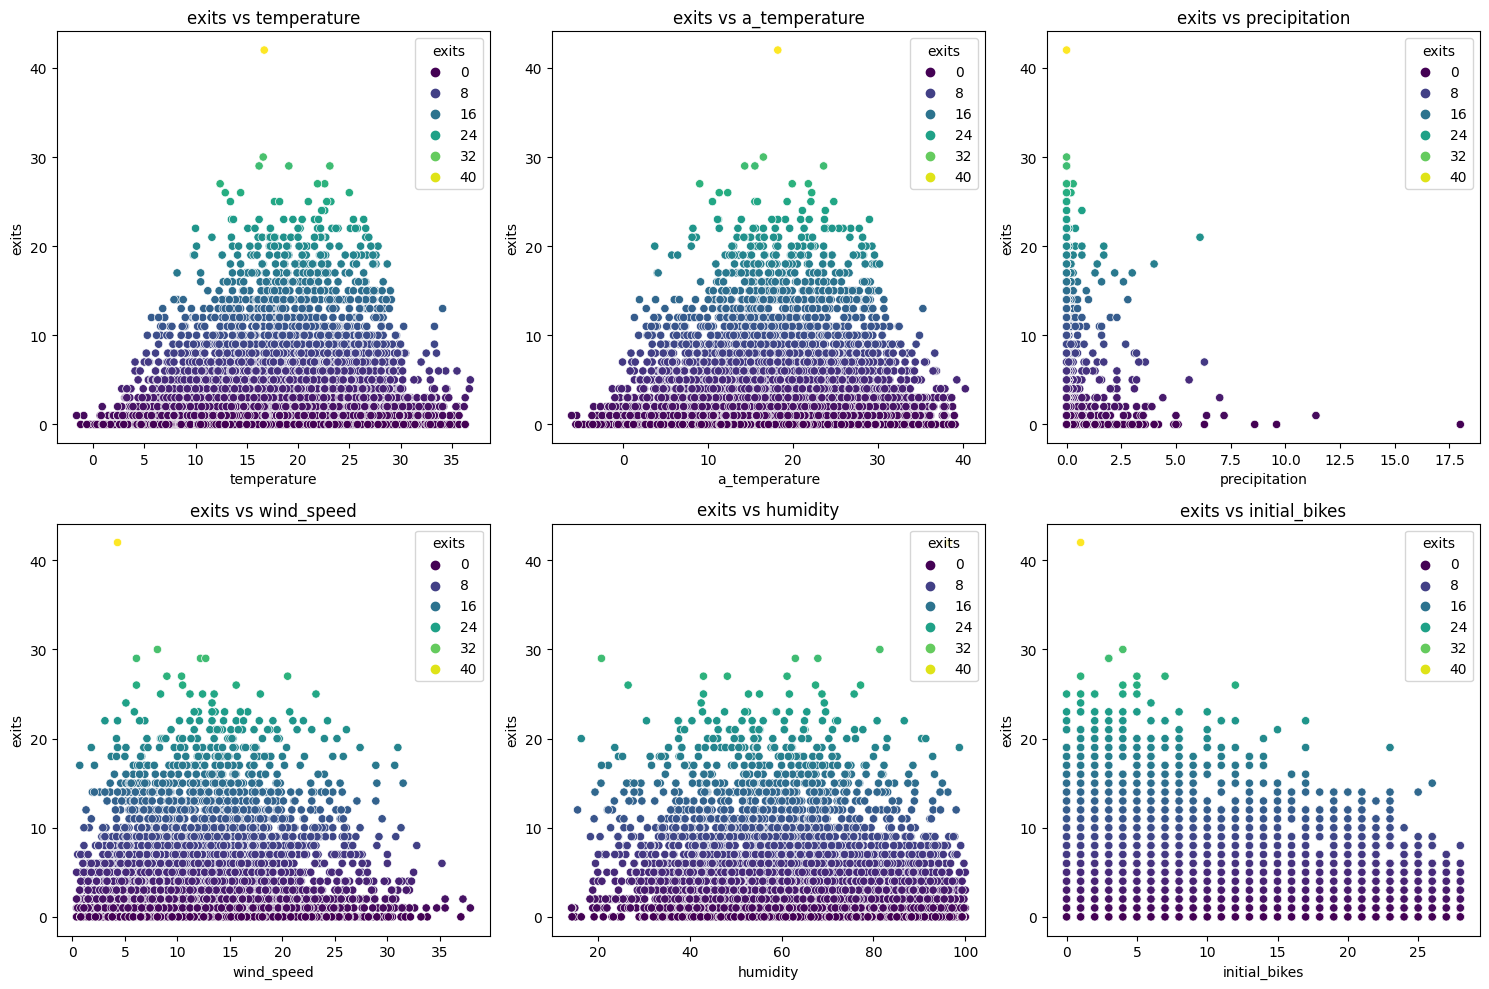

In [9]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity","initial_bikes"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=filtered_data, x=var, y="exits", hue='exits', palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

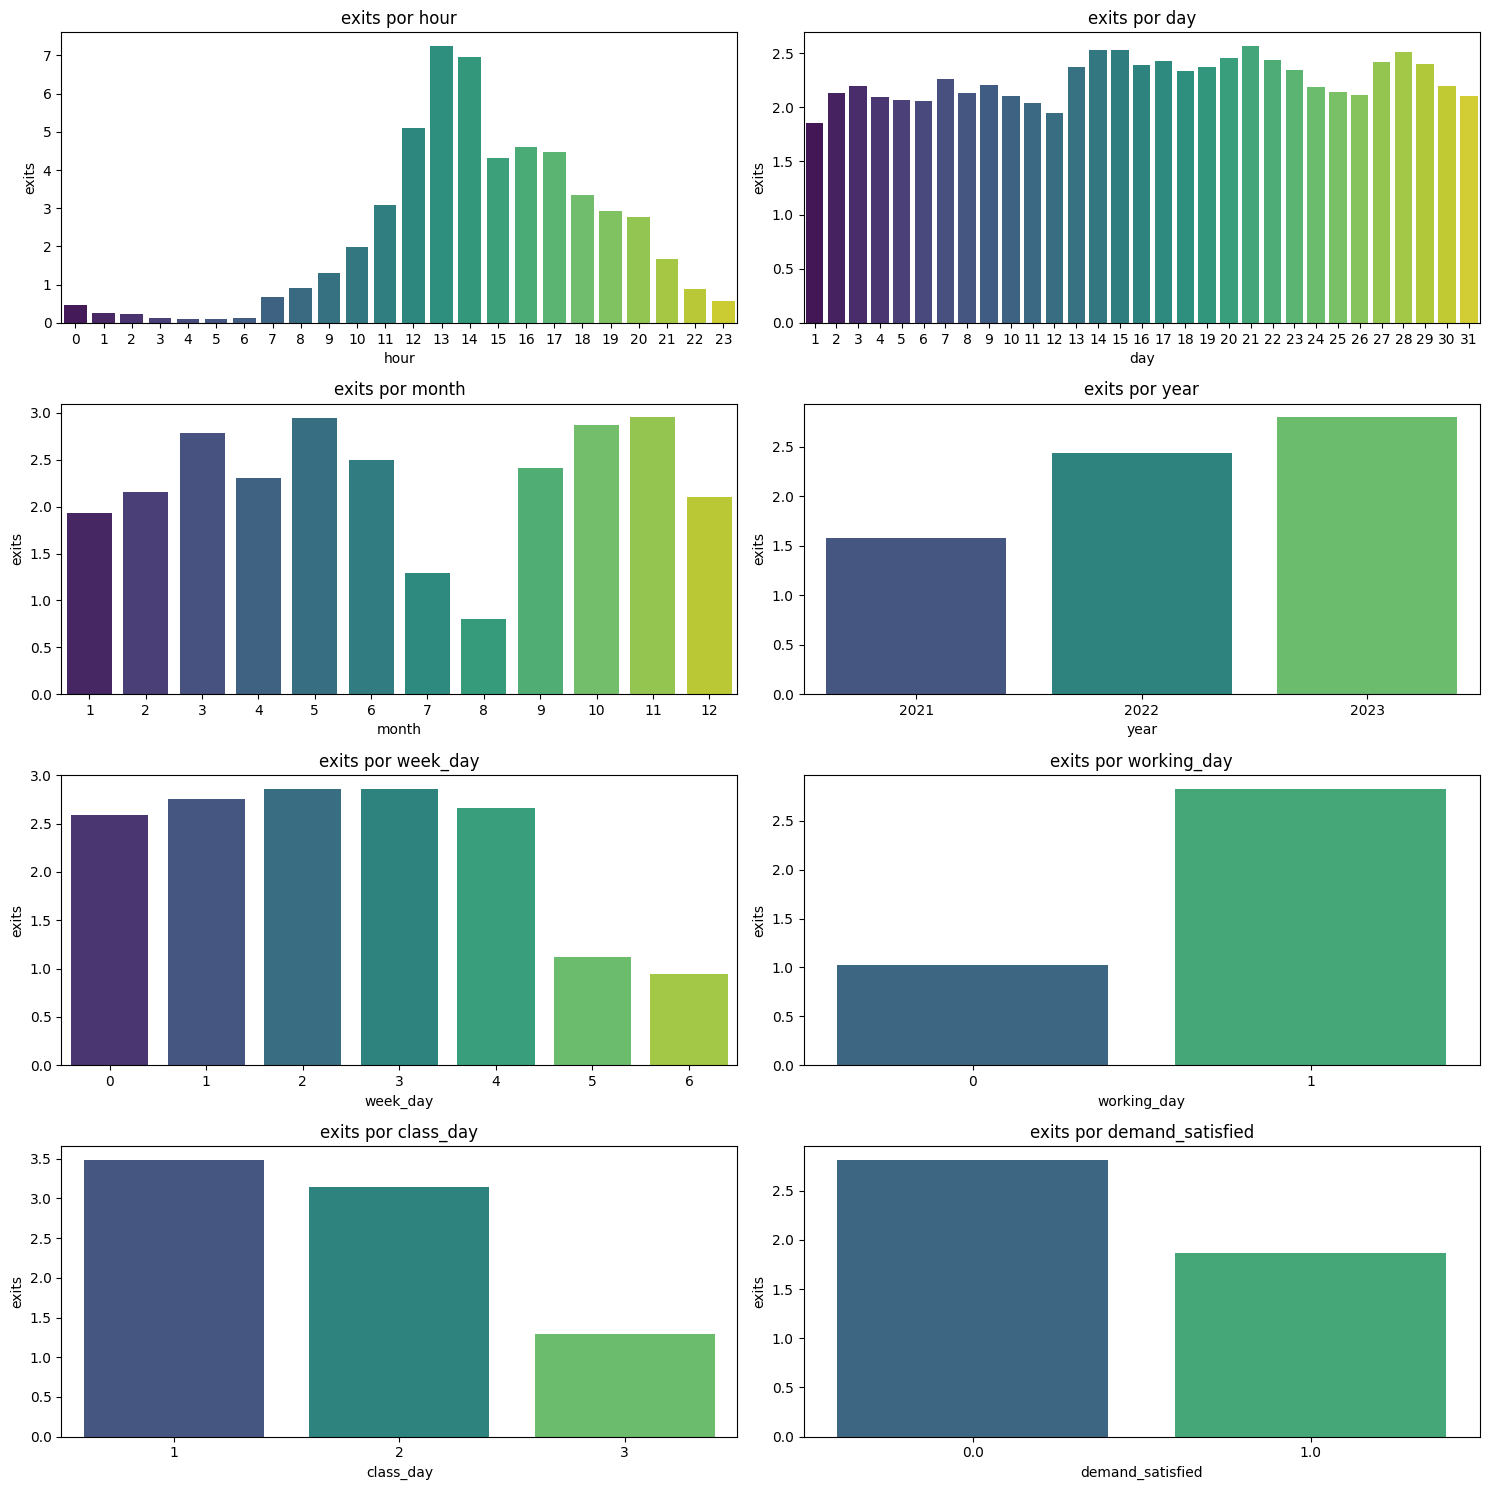

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None, palette="viridis")
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

<Axes: >

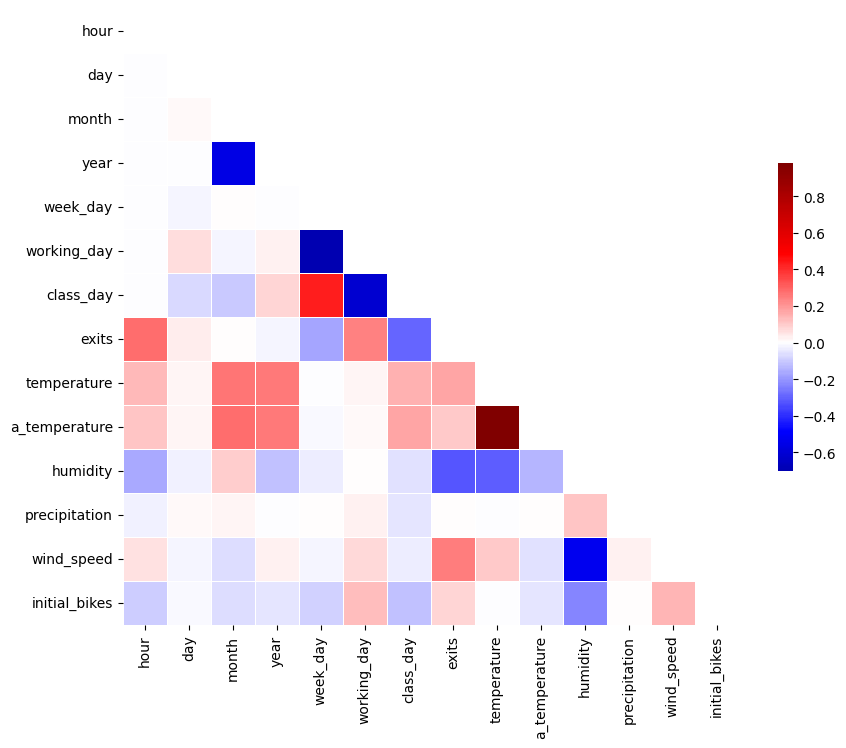

In [11]:
corr = filtered_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

---
# **Aplicacion de los modelos**
---
## **Modelos Lineales**

Creamos un dataframe llamada results_df para ir guardando y poder mejor las metricas de nuestros modelos

In [12]:
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE', 'RMSE', 'MAE', 'Explained Variance Score'])

### **Linear Regresion**

In [13]:
# Preparar los datos para la regresión
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

split_index = int(len(X) - 24)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((9456, 14), (24, 14), (9456,), (24,))

In [14]:
from cmath import sqrt

# Create the linear regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = linear_reg.predict(X_test)

# Evaluate the model on the test set
r2_score_lr = linear_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
explained_variance = explained_variance_score(y_test, y_pred_lr)

# Add the results to the dataframe
results_df.loc[0] = ["Linear Regression", r2_score_lr, mse, sqrt(mse), mae, explained_variance]

results_df



,Model,R2 Score,MSE,RMSE,MAE,Explained Variance Score
0,Linear Regression,0.319845,21.584301,4.645891+0.000000j,3.251817,0.334165


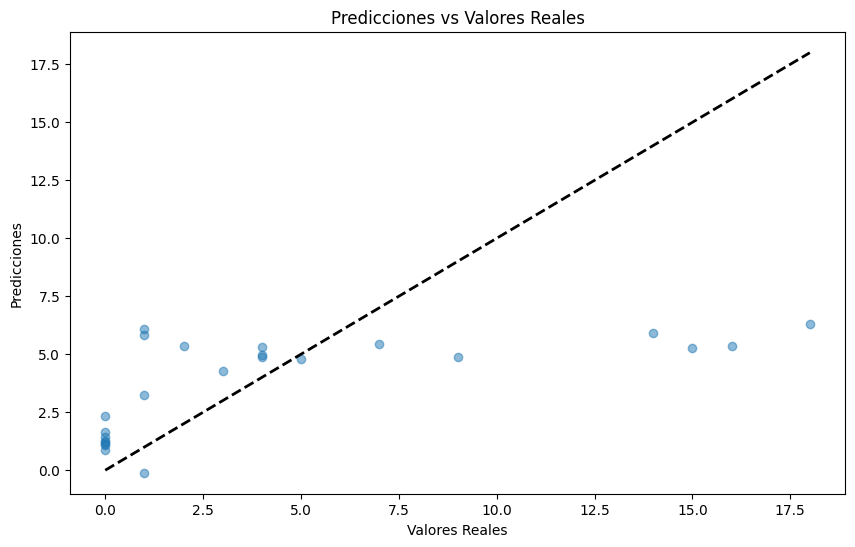

In [15]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

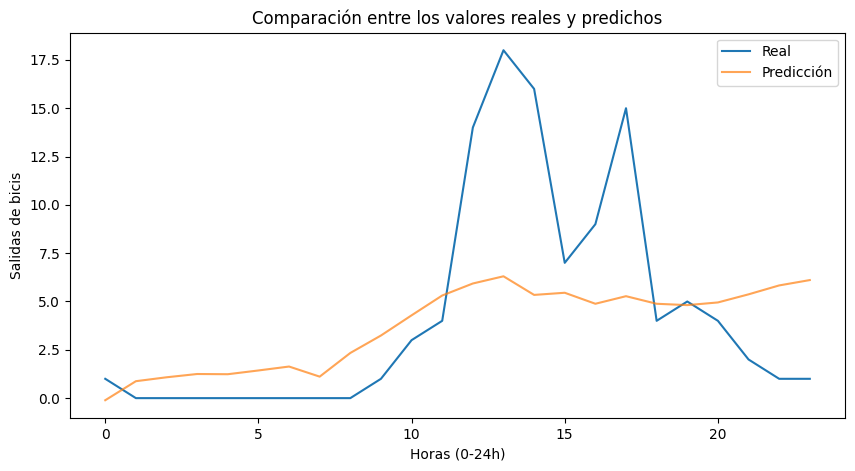

In [16]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_lr, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

### **K-Nearest Neighbours**

Per KNN cal normalitzar les variables numeriques

In [35]:
from sklearn.preprocessing import StandardScaler

# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
filtered_data_one = pd.get_dummies(filtered_data, columns=categorical_vars_selected)

X = filtered_data_one.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data_one['exits']

split_index = int(len(X) - 730)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

X_train[numeric_vars_without_exits] = scaler.fit_transform(X_train[numeric_vars_without_exits])
X_test[numeric_vars_without_exits] = scaler.transform(X_test[numeric_vars_without_exits])

<ipython-input-35-a632a05cee58>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_vars_without_exits] = scaler.fit_transform(X_train[numeric_vars_without_exits])
<ipython-input-35-a632a05cee58>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_vars_without_exits] = scaler.transform(X_test[numeric_vars_without_exits])


In [39]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_space_knn = {
    'n_neighbors': (3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the KNN model
knn = KNeighborsRegressor()

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for KNN
knn_bs = BayesSearchCV(
    knn,
    param_space_knn,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the KNN model with BayesSearchCV
knn_bs.fit(X_train, y_train)

# Best model and parameters found
best_knn_bs = knn_bs.best_estimator_
best_params_knn_bs = knn_bs.best_params_

# Evaluate the model on the test set
y_pred_knn_bs = best_knn_bs.predict(X_test)
r2_score_knn_bs = r2_score(y_test, y_pred_knn_bs)

# Print the best parameters and R2 score for KNN with BayesSearchCV
print("Best parameters for KNN (BayesSearchCV):", best_params_knn_bs)
mse_knn_bs = mean_squared_error(y_test, y_pred_knn_bs)
mae_knn_bs = mean_absolute_error(y_test, y_pred_knn_bs)
explained_variance_knn_bs = explained_variance_score(y_test, y_pred_knn_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[1] = ["K-Nearest Neighbors", r2_score_knn_bs, mse_knn_bs, sqrt(mse_knn_bs), mae_knn_bs, explained_variance_knn_bs]

# Print or use results_df as needed
print(results_df)


Best parameters for KNN (BayesSearchCV): OrderedDict([('n_neighbors', 20), ('p', 1), ('weights', 'distance')])
                 Model  R2 Score        MSE                RMSE       MAE  \
0    Linear Regression  0.319845  21.584301  4.645891+0.000000j  3.251817   
1  K-Nearest Neighbors  0.647956   8.336296  2.887264+0.000000j  2.003020   

   Explained Variance Score  
0                  0.334165  
1                  0.648729  


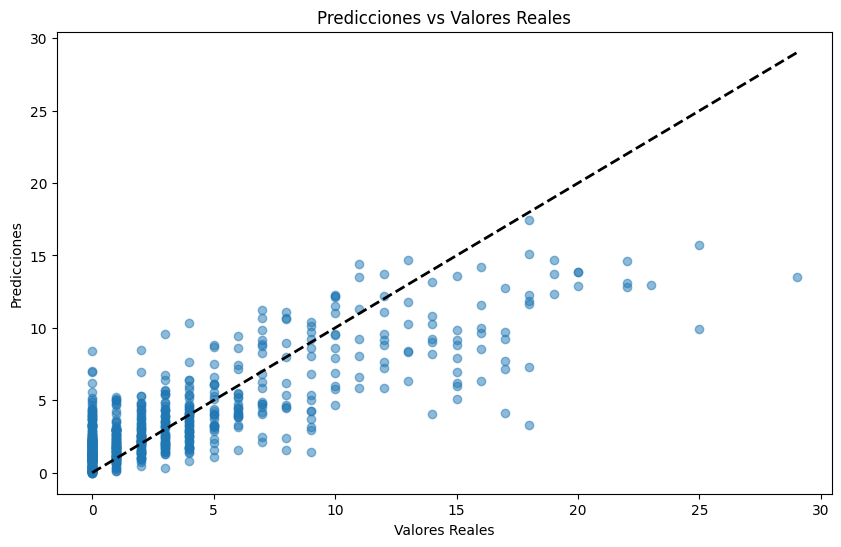

In [40]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn_bs, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

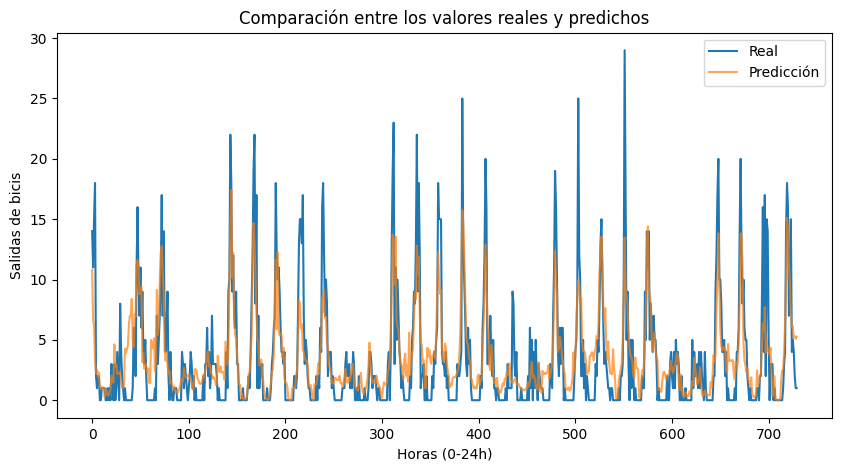

In [41]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_knn_bs, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

### **SVM con Kernel POLY**

Para este modelo, no solo necesitamos estandarizar las variables numericas, sino tambien hara falta hace one-hot encoding de las variables numericas

In [28]:
# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
filtered_data_one = pd.get_dummies(filtered_data, columns=categorical_vars_selected)

X = filtered_data_one.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data_one['exits']

split_index = int(len(X) - 24)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

X_train[numeric_vars_without_exits] = scaler.fit_transform(X_train[numeric_vars_without_exits])
X_test[numeric_vars_without_exits] = scaler.transform(X_test[numeric_vars_without_exits])


,exits,temperature,a_temperature,humidity,precipitation,wind_speed,initial_bikes,hour_0,hour_1,hour_2,...,week_day_6,working_day_0,working_day_1,class_day_1,class_day_2,class_day_3,demand_satisfied_0.0,demand_satisfied_1.0,demand_satisfied_lag_0.0,demand_satisfied_lag_1.0
16056,0,0.126021,0.331314,1.283952,-0.136492,-0.523820,0.0,1,0,0,...,0,1,0,0,0,1,1,0,1,0
16057,0,0.082893,0.150437,0.987828,0.548134,0.429880,0.0,0,1,0,...,0,1,0,0,0,1,1,0,1,0
16058,0,0.097269,0.252180,1.166620,0.548134,-0.276564,2.0,0,0,1,...,0,1,0,0,0,1,0,1,1,0
16059,1,0.039766,0.252180,1.267190,-0.136492,-0.806397,2.0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
16060,0,0.011014,0.218266,1.295127,-0.136492,-0.629786,3.0,0,0,0,...,0,1,0,0,0,1,0,1,0,1


In [ ]:
# Define the parameter search space for SVM with polynomial kernel
param_space_svm_poly = {
    'C': (0.1, 10.0, 'log-uniform'),
    'gamma': ('scale', 'auto'),
    'degree': (2, 4)
}

# Create the SVM model with polynomial kernel
svm_poly = SVR(kernel='poly')

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for SVM with polynomial kernel
svm_poly_bs = BayesSearchCV(
    svm_poly,
    param_space_svm_poly,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the SVM model with BayesSearchCV
svm_poly_bs.fit(X_train, y_train)

# Best model and parameters found
best_svm_poly_bs = svm_poly_bs.best_estimator_
best_params_svm_poly_bs = svm_poly_bs.best_params_

# Evaluate the model on the test set
y_pred_svm_poly_bs = best_svm_poly_bs.predict(X_test)
r2_score_svm_poly_bs = r2_score(y_test, y_pred_svm_poly_bs)

# Print the best parameters and R2 score for SVM with polynomial kernel using BayesSearchCV
print("Best parameters for SVM with polynomial kernel (BayesSearchCV):", best_params_svm_poly_bs)
mse_svm_poly_bs = mean_squared_error(y_test, y_pred_svm_poly_bs)
mae_svm_poly_bs = mean_absolute_error(y_test, y_pred_svm_poly_bs)
explained_variance_svm_poly_bs = explained_variance_score(y_test, y_pred_svm_poly_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[2] = ["SVM with Polynomial Kernel", r2_score_svm_poly_bs, mse_svm_poly_bs, sqrt(mse_svm_poly_bs), mae_svm_poly_bs, explained_variance_svm_poly_bs]

# Print or use results_df as needed
print(results_df)


In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm_poly_bs, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_svm_poly_bs, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

## **Modelos No Lineales**

### **Random Forest**

In [ ]:

# Preparar los datos para la regresión
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

# Crear ventanas deslizantes
window_size = 24  # Tamaño de la ventana (ajustar según sea necesario)
X_windows = sliding_window_view(X.to_numpy(), window_shape=(window_size,), axis=0)
y_windows = y[window_size-1:].to_numpy()

# Aplanar las ventanas para usar en el modelo
X_windows_flat = X_windows.reshape(-1, window_size * X.shape[1])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_windows_flat, y_windows, test_size=0.15, shuffle=False)


In [ ]:
# Define the parameter grid
# param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    # 'max_features': ['auto', 'sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
}

# Crear el modelo Random Forest
rf = RandomForestRegressor()

# Configurar TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configurar BayesSearchCV
rf_bs = BayesSearchCV(
    rf,
    param_grid,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Ajustar el modelo con BayesSearchCV
rf_bs.fit(X_train, y_train)

# Mejor modelo y parámetros encontrados
best_rf = rf_bs.best_estimator_
best_params = rf_bs.best_params_

# Evaluar el modelo en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)
r2_score_rf = r2_score(y_test, y_pred)

# Imprimir los mejores parámetros y el puntaje R2
print("Mejores parámetros:", best_params)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

results_df.loc[len(results_df)] = ["Random Forest", r2_score_rf, mse, sqrt(mse), mae, explained_variance]

results_df

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Valores Reales')

Text(0, 0.5, 'Predicciones')

Text(0.5, 1.0, 'Predicciones vs Valores Reales')

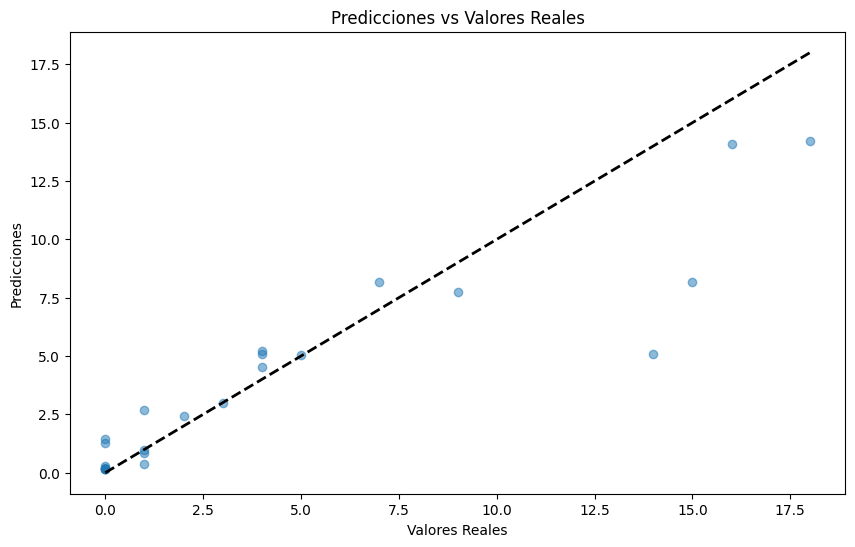

Root Mean Squared Error (RMSE): (2.562573676526572+0j)
Mean Squared Error (MSE): 6.566783847626913
Mean Absolute Error (MAE): 1.3966379977102645
Explained Variance Score: 0.8031246468244475


In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Comparación entre los valores reales y predichos')

Text(0.5, 0, 'Índice de los datos')

Text(0, 0.5, 'Salidas de bicis')

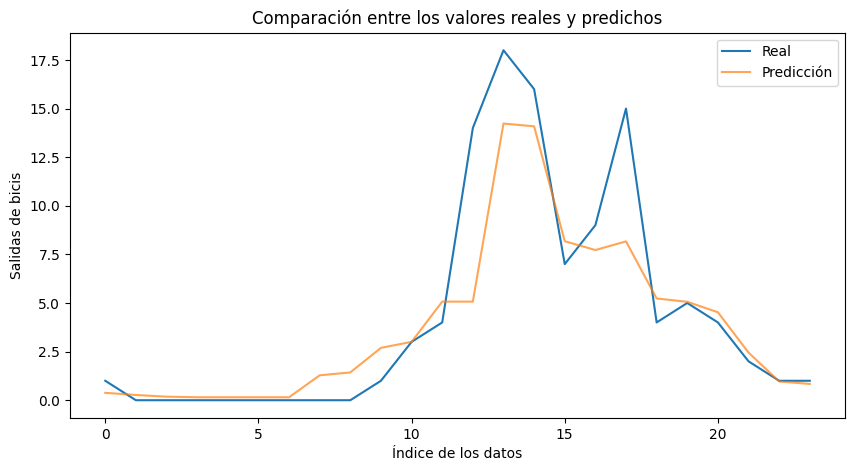

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_rf, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

### **Gradient Boosting**

In [ ]:

# Preparar los datos para la regresión
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data['exits']

# Crear ventanas deslizantes
window_size = 24  # Tamaño de la ventana (ajustar según sea necesario)
X_windows = sliding_window_view(X.to_numpy(), window_shape=(window_size,), axis=0)
y_windows = y[window_size-1:].to_numpy()

# Aplanar las ventanas para usar en el modelo
X_windows_flat = X_windows.reshape(-1, window_size * X.shape[1])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_windows_flat, y_windows, test_size=0.15, shuffle=False)


In [ ]:
# Define the parameter search space for Gradient Boosting
param_space_gb = {
    'n_estimators': (100, 300),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'learning_rate': (0.01, 0.2, 'uniform')
}

# Create the Gradient Boosting model
gb = GradientBoostingRegressor()

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for Gradient Boosting
gb_bs = BayesSearchCV(
    gb,
    param_space_gb,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the Gradient Boosting model with BayesSearchCV
gb_bs.fit(X_train, y_train)

# Best model and parameters found
best_gb = gb_bs.best_estimator_
best_params_gb = gb_bs.best_params_

# Evaluate the model on the test set
y_pred_gb = best_gb.predict(X_test)
r2_score_gb = r2_score(y_test, y_pred_gb)

# Print the best parameters and R2 score for Gradient Boosting with BayesSearchCV
print("Best parameters for Gradient Boosting (BayesSearchCV):", best_params_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
explained_variance_gb = explained_variance_score(y_test, y_pred_gb)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["Gradient Boosting", r2_score_gb, mse_gb, sqrt(mse_gb), mae_gb, explained_variance_gb]

# Print or use results_df as needed
print(results_df)


In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_gb, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

### **MLP**

In [ ]:
# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
filtered_data_one = pd.get_dummies(filtered_data, columns=categorical_vars_selected)

X = filtered_data_one.drop(['exits', 'demand_satisfied'], axis=1)
y = filtered_data_one['exits']

split_index = int(len(X) - 24)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

X_train[numeric_vars_without_exits] = scaler.fit_transform(X_train[numeric_vars_without_exits])
X_test[numeric_vars_without_exits] = scaler.transform(X_test[numeric_vars_without_exits])

In [ ]:
# Define the parameter search space for MLP
param_space_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': (1e-5, 1e-2, 'log-uniform'),
    'learning_rate_init': (0.001, 0.1, 'log-uniform')
}

# Create the MLP model
mlp = MLPRegressor(max_iter=1000)

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for MLP
mlp_bs = BayesSearchCV(
    mlp,
    param_space_mlp,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the MLP model with BayesSearchCV
mlp_bs.fit(X_train, y_train)

# Best model and parameters found
best_mlp = mlp_bs.best_estimator_
best_params_mlp = mlp_bs.best_params_

# Evaluate the model on the test set
y_pred_mlp = best_mlp.predict(X_test)
r2_score_mlp = r2_score(y_test, y_pred_mlp)

# Print the best parameters and R2 score for MLP with BayesSearchCV
print("Best parameters for MLP (BayesSearchCV):", best_params_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
explained_variance_mlp = explained_variance_score(y_test, y_pred_mlp)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["MLP", r2_score_mlp, mse_mlp, sqrt(mse_mlp), mae_mlp, explained_variance_mlp]

# Print or use results_df as needed
print(results_df)

In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_mlp, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas (0-24h)')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();